In [1]:
# prepare libs

import os
# from tqdm.autonotebook import tqdm, trange
from tqdm import tqdm, trange


import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time

import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

import PIL
print(PIL.__version__)
print ("all libs imported")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


9.5.0
all libs imported


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')


In [3]:
# get images
# !ls -la drive/MyDrive/Stepik_ML/pinocchio

# !unzip drive/MyDrive/Stepik_ML/pinocchio/journey-springfield.zip -d drive/MyDrive/Stepik_ML/pinocchio/images



In [4]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [5]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            self.classes = self.label_encoder.classes_


            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [6]:
#определим директории с тренировочными и тестовыми файлами
# PATH_TO_IMAGES = 'drive/MyDrive/Stepik_ML/pinocchio/images'
# TRAIN_DIR = Path(PATH_TO_IMAGES + '/train/')
# TEST_DIR = Path(PATH_TO_IMAGES + '/testset')

TRAIN_DIR = Path('../input/journey-springfield-zip/train/')
TEST_DIR = Path('../input/journey-springfield-zip/testset')

print(f'TRAIN_DIR is {TRAIN_DIR}')
print(f'TEST_DIR is {TEST_DIR}')


TRAIN_DIR is ../input/journey-springfield-zip/train
TEST_DIR is ../input/journey-springfield-zip/testset


In [7]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [8]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [9]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [10]:
val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(train_files, mode='val')

In [11]:
num_unique_labels = len(val_dataset.classes)
print(f"Количество уникальных меток в val_dataset: {num_unique_labels}")
num_unique_labels_train = len(train_dataset.classes)
print(f"Количество уникальных меток в train_dataset: {num_unique_labels_train}")


Количество уникальных меток в val_dataset: 42
Количество уникальных меток в train_dataset: 42


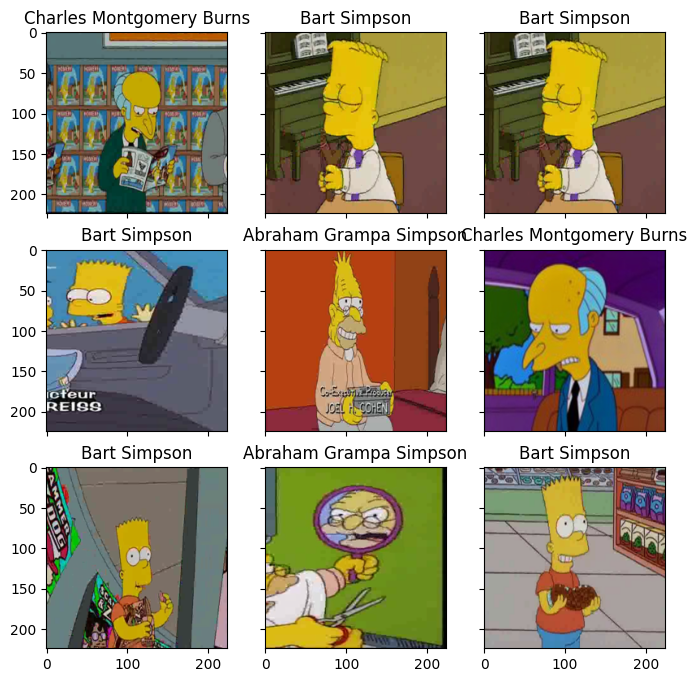

In [12]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [13]:
#функция для тренировки модели

use_gpu = torch.cuda.is_available()

batch_size = 4

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
dataloaders = {
    'train': train_loader,
    'val': val_loader
    }
dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset)
}

class_names = train_dataset.classes


def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    losses = {'train': [], 'val': []}

    pbar = trange(num_epochs, desc="Epoch:")

    for epoch in pbar:
        # Каждая эпоха имеет обучающую и тестовую стадии
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Установить модель в режим обучения
            else:
                model.eval()   # Установить модель в режим оценки

            running_loss = 0.0
            running_corrects = 0

            for data in dataloaders[phase]:
                inputs, labels = data

                if use_gpu:
                    inputs = inputs.cuda()
                    labels = labels.cuda()

                # Инициализируем градиенты параметров
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    preds = torch.argmax(outputs, -1)
                    loss = criterion(outputs, labels)

                    # Backward pass + оптимизация только если это стадия обучения
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Статистика
                running_loss += loss.item()
                running_corrects += int(torch.sum(preds == labels.data))

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            losses[phase].append(epoch_loss)

            pbar.set_description('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # Обновление планировщика скорости обучения
            if phase == 'train':
                scheduler.step()

            # Запоминаем лучшие веса модели, если достигнуто лучшее качество на валидации
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    # загрузим лучшие веса модели
    model.load_state_dict(best_model_wts)
    return model, losses


In [14]:
# Функция для отрисовки тестовых изображений и предсказаний для них:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images // 2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

In [15]:
# Функция для измерения точности модели на валидационном датасете
def evaluate(model):
    model.eval()

    runninig_correct = 0
    for data in dataloaders['val']:
        # получаем картинки и метки
        inputs, labels = data

        # переносим на gpu, если возможно
        if use_gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()

        # forard pass
        output = model(inputs)
        _, predicted = torch.max(output, 1)

        runninig_correct += int(torch.sum(predicted == labels))

    return runninig_correct / dataset_sizes['val']

In [16]:
# импортируем AlexNet
# model = models.alexnet(pretrained=True)
# Если вам нужна последняя версия весов (если таковая имеется), 
# вы можете использовать AlexNet_Weights.DEFAULT. 
# Это обеспечит загрузку самой актуальной версии предобученных весов для данной модели.
from torchvision.models import alexnet, AlexNet_Weights
model = alexnet(weights=AlexNet_Weights.IMAGENET1K_V1)


In [17]:
# посмотрим, что внутри
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

**Fine Tuning способ**





Сконфигурируем - изменим FC-слой и зададим cost function и оптимизирующий алгоритм:

(по умолчанию backpropagation распространяется на все слои, поэтому здесь мы только заменяем FC-слой на свой классификатор)

In [18]:
# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 9216
# Заменяем Fully-Connected слой на наш линейный классификатор
model.classifier = nn.Linear(num_features, 42)

# Использовать ли GPU
if use_gpu:
    model = model.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# В качестве оптимизатора - стохастический градиентный спуск
optimizer_ft = optim.Adam(model.parameters(), lr=1e-4)

# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [19]:
model, losses = train_model(model, loss_fn, optimizer_ft, exp_lr_scheduler, num_epochs=25)

val Loss: 0.2172 Acc: 0.9194: 100%|██████████| 25/25 [1:03:04<00:00, 151.40s/it]  


Training complete in 63m 5s
Best val Acc: 0.919947


TypeError: cannot unpack non-iterable NoneType object

In [20]:
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.4)

# Построим график лосса при обучении и валидации

#Ваш код здесь
plt.figure(figsize=(12, 8))
plt.plot(losses['train'], label="train")
plt.plot(losses['val'], label="val")
plt.legend()
plt.show()

NameError: name 'losses' is not defined

<Figure size 1200x800 with 0 Axes>

In [23]:
torch.save(model.state_dict(), 'AlexNet_fine_tune_2.pth')
print("success")

success


In [24]:
model.load_state_dict(torch.load('AlexNet_fine_tune_2.pth'))

<All keys matched successfully>

In [25]:
print("Accuracy: {0:.4f}".format(evaluate(model)))

Accuracy: 0.9194


In [26]:
!ls -la .

total 11184
drwxr-xr-x 3 root root     4096 Dec 15 14:24 .
drwxr-xr-x 5 root root     4096 Dec 15 12:47 ..
drwxr-xr-x 2 root root     4096 Dec 15 12:47 .virtual_documents
-rw-r--r-- 1 root root 11431693 Dec 15 14:26 AlexNet_fine_tune.pth
-rw-r--r-- 1 root root     4271 Dec 15 13:18 label_encoder.pkl
